# Simulation 

We will clone a repository with a test example for the NEBM and use the data files produced by the simulation:

In [1]:
!git clone https://github.com/fangohr/paper-2016-Cortes-etal-NEBM-test-system.git

Cloning into 'paper-2016-Cortes-etal-NEBM-test-system'...
remote: Counting objects: 103, done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 103 (delta 0), reused 0 (delta 0), pack-reused 100
Receiving objects: 100% (103/103), 4.33 MiB | 877.00 KiB/s, done.
Resolving deltas: 100% (48/48), done.


In [2]:
%%capture
!cd paper-2016-Cortes-etal-NEBM-test-system && make relaxation
!cd paper-2016-Cortes-etal-NEBM-test-system && make nebm

# NEBM Plot Functions

Once that the data is generated, we import the NEBM plot library:

In [1]:
import sys
sys.path.append('..')
import nebm_plot_functions as npf
import npf_colormaps as npf_cm

import matplotlib.pyplot as plt

../nebm_plot_functions.py:14: UserWarning: The Energy scale is in Joules. If you want to use a different energy scale, you can redefine the neb_plot_functions.scale variable and, to change the labels, use the neb_plot_functions.scale_label variable. In this way, the energy data will be divided by *scale*, e.g. 
 import neb_plot_functions as npf 
npf.scale = 1000 
npf.scale_label = 'kJ' 
  warnings.warn(imp_message)


To get a nice style for the plots, we can use the `Lato` font. There are different functions defined in `npf` to replace the default matplotlib settings, we will use the one that can be used together with `%matplotlib inline`:

In [2]:
%matplotlib inline
npf.set_matplotlib_Lato()

## Data

We will use this folder as the root folder for the plot functions. Many plot functions assume that the *npys* and *vtks* folders are on this root folder that we can specify using the `rel_folder` argument.

In [3]:
base_folder = 'paper-2016-Cortes-etal-NEBM-test-system/'

### Energy plot

A simple plot with the energy of the images with respect to the *distance* from the first image ($\mathbf{Y}_{0}$). The distance definition depends on the coordinates system and they are saved on the `*_dYs.ndt` file as distances between neighbouring images. NPF sum these distances from the first image. We can specify more than one list to have several curves at different iterations or from different simulations. If we didn't specify the energy scale globally using `npf.SCALE =`, we can manually set this with the `scale` argument, the same for the label.

Every list to plot the curves must contain:

    [energy_ndt_file, dYs_ndt_file, legend_label, iteration_step]

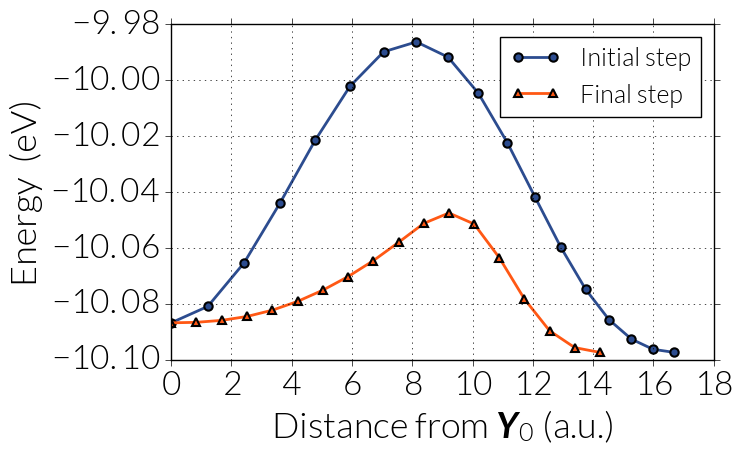

In [4]:
p = npf.plot_dist_vs_energy([
['neb_21x21-spins_fm-sk_atomic_k1e4_energy.ndt', 
 'neb_21x21-spins_fm-sk_atomic_k1e4_dYs.ndt', 
 r'Initial step', 0],
['neb_21x21-spins_fm-sk_atomic_k1e4_energy.ndt', 
 'neb_21x21-spins_fm-sk_atomic_k1e4_dYs.ndt', 
 r'Final step', -1],
],
legend_position='upper right',
# savef="energy.pdf"
scale=1.602e-19, scale_label='eV',
num_labels=None,
rel_folder=base_folder
)

The NEBM class in Fidimag includes a method to interpolate the energy data points using a cubic polynomial with information from the tangents and gradients of every image. This allows to have a better estimate of the saddle point (for this case the largest energy point). We include an option in NPF to call this method and plot the approximation of the band, but we need to specify the NEBM simulation exactly as we did to produce the data:

In [5]:
from fidimag.atomistic import Sim
from fidimag.common import CuboidMesh
from fidimag.atomistic import DMI
from fidimag.atomistic import UniformExchange
from fidimag.atomistic import Zeeman
# Import physical constants from fidimag
import fidimag.common.constant as const
from fidimag.common.nebm_geodesic import NEBM_Geodesic
# ------------------------------------------

mesh = CuboidMesh(nx=21, ny=21,
                  dx=0.5, dy=0.5,
                  unit_length=1e-9,
                  periodicity=(True, True, False)
                  )
sim = Sim(mesh, name='neb_21x21-spins_fm-sk_atomic')
sim.gamma = const.gamma
sim.mu_s = 2 * const.mu_B
sim.add(UniformExchange((10.0 / 1.) * const.meV))
sim.add(DMI((6 / 1.) * const.meV, dmi_type='interfacial'))
sim.add(Zeeman((0, 0, 25.)))


Accordingly, we must pass the path to the folder with the *npys* file to get the information from the spin field (for this case the path is relative to `rel_folder`). The paths is specified as a 5th element on the lists to plot the curves. This is done for every curve we want to interpolate. The interpolation of the curve is set up with the `interpolate_energy` argument which is a list with the NEBM class used to produce the data, the Fidimag simulation object and the number of points for the interpolation.

Additionally, we use the `energy_shift` argument to shift the energy scale with respect to the image labelled with the integer specified on this argument, i.e. here we shift the image with respect to the 0-th image energy. There are additional options to style the plot, take a look to `npf.plot_dist_vs_energy?`

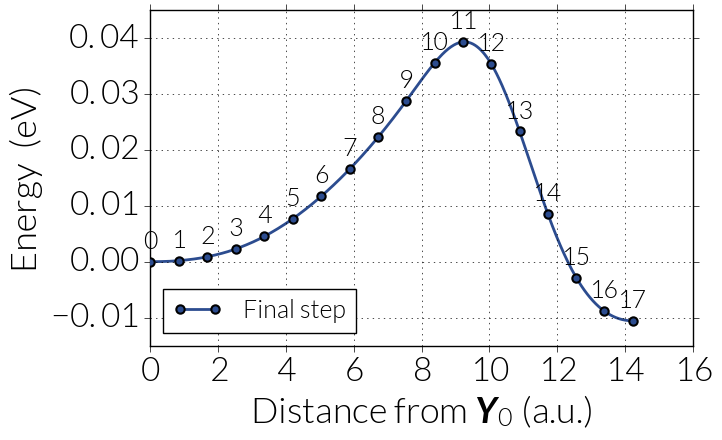

In [6]:
p = npf.plot_dist_vs_energy([
['neb_21x21-spins_fm-sk_atomic_k1e4_energy.ndt', 
 'neb_21x21-spins_fm-sk_atomic_k1e4_dYs.ndt', 
 'Final step', -1,
 'npys/neb_21x21-spins_fm-sk_atomic_k1e4_97'
 ],
],
interpolate_energy=[NEBM_Geodesic, sim, 500],
legend_position='lower left',
# savef="energy.pdf"
scale=1.602e-19, scale_label='eV',
rel_folder=base_folder,
energy_shift=0,
ylim=[-0.015, 0.045]
)

### Magnetisation plot

Similarly to the energy plot, we can plot the average spin/magnetisation from the whole sample, which is normalised. Since we need the spin/magnetisation field from every image to calculate the averages, the argument is the simulation object used to produce the data. 

The second argument is a 3 elements tuple with booleans indicating which components we want to plot for every list. For this case, the lists to plot the curves are specified with

    [dYs_ndt_file, legend_label, iteration_step, simulation_name, *energy_ndt_file*]
    
where the last energy file name is optional. When specified, the plot shows the energy with the scale on the right axis. We can even specify to interpolate the energy curve. For this case, the `interpolate_energy` will have only two arguments, the NEBM class and the number of points, since the simulation was already specified as the first argument of the plot function. The scaling of this energy curve can be specified with the same arguments than the `plot_energy_vs_distance` function. 

For the annotation of curves, we specify which set of `m` curves are annotated with the `num_labels` list, i.e. if we have two curves and we only want the
second one annotated we use `num_labels=[1]`. In the exmaple below there is only one curve so we use `num_labels=[0]`. Furthermore, we can scale the position of the annotations using the `num_scale` list. This list can be a list of lists or a list of floats or a mix of both and the specification goes according to the `num_labels` list. If it is a list of lists, then the list must contain the same number of `True` elements than the tuple to specify the `m` components, where every element is a scale for the `m_{}` curve. If we specify a float, all the `m_{}` will have the same scaling.

For example, if we have two curves and:

    npf.plot_dist_vs_m(sim, (True, False, True),
    [[m_curves 0], [m_curves 1]],
    ...
    num_labels=[1, 0],
    num_scale=[[-1, 2], -5],
    ...)
    
Then, for `m_curves 1`, `m_x` and `m_z`  will be scaled by `-1` and `2` respectively. And for `m_curves 0`, `m_x` and `m_z` are scaled by a factor of `-5`.
The example below is more simple.

The legend is automatically generated to differentiate every set of curves:

/home/david/anaconda3/lib/python3.5/site-packages/matplotlib/mathtext.py:857: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


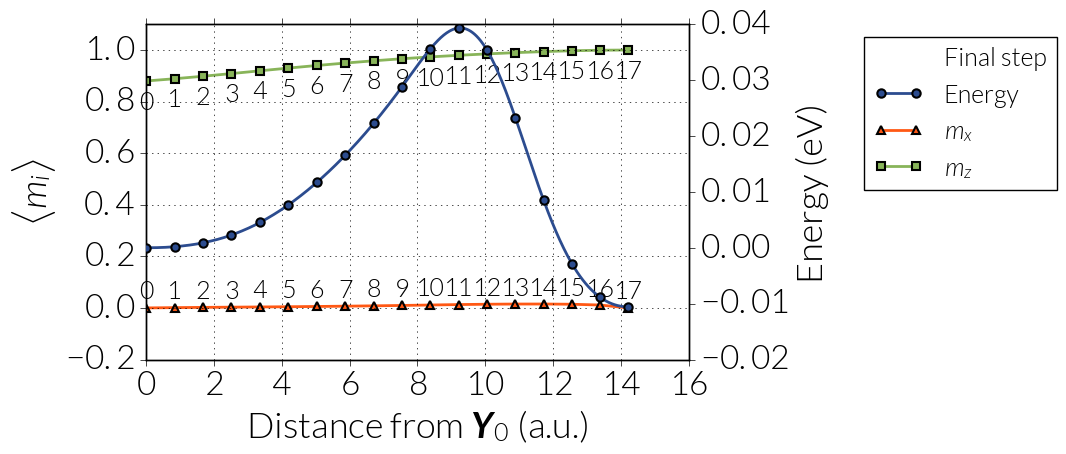

In [7]:
p = npf.plot_dist_vs_m(sim,
(True, False, True),
[
['neb_21x21-spins_fm-sk_atomic_k1e4_dYs.ndt', 
 r'Final step',
 97, 'neb_21x21-spins_fm-sk_atomic_k1e4',
 'neb_21x21-spins_fm-sk_atomic_k1e4_energy.ndt'
 ]],
num_labels=[0],
num_scale=[[2, -0.09]],
legend_position=(1.3, 1.),
rel_folder=base_folder,
ylim=[-0.2, 1.1],
secondary_axis=[1.602e-19, 'eV'],
energy_shift=0,
interpolate_energy=[NEBM_Geodesic, 500]
)

### Skyrmion number (topological charge) plot

This plot follows the same logic than the other plots. Since we have to compute the average skyrmion number (or topological charge) we have to pass a simulation object as first argument and the `npys` folder in the lists together with the iteration step. An energy plot with optional interpolation is also possible.

The number annotation is the same than in the energy plot.

The calculation of the skyrmion number can be done with different methods from Fidimag, the default one is `FiniteSpinChirality` but we can also use the `BergLuscher` method with the `sk_number_method` argument. This is only allowed for Fidimag plots.

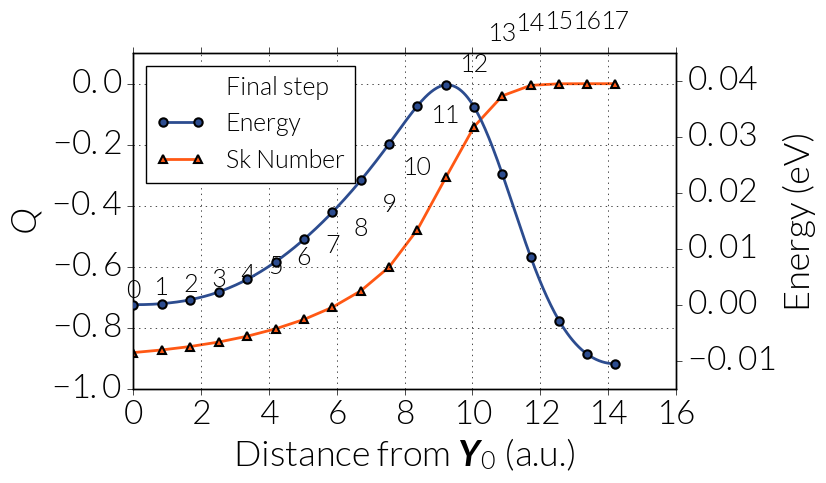

In [8]:
p = npf.plot_dist_vs_sknum(sim,
[
['neb_21x21-spins_fm-sk_atomic_k1e4_dYs.ndt', 
 r'Final step',
 97, 'neb_21x21-spins_fm-sk_atomic_k1e4',
 'neb_21x21-spins_fm-sk_atomic_k1e4_energy.ndt'
 ]],
num_scale=0.2,
legend_position='upper left',
rel_folder=base_folder,
ylim=[-1, 0.1],
ylim_en=[-0.015, 0.045],
secondary_axis=[1.602e-19, 'eV'],
energy_shift=0,
interpolate_energy=[NEBM_Geodesic, 500],
# sk_number_method='BergLuscher'
)

## Mayavi snapshots

The NPF library includes a Mayavi based function to plot the images snapshots using the simulations VTK files. For this, we need to specify the name of the folder with the VTK files under the `{rel_folder}/vtks/` directory. These snapshots can be joined into a single file showing the snapshots in a grid. Extra arguments can be seen under the function documentation: `npf.plot_mayavi2?`

In [9]:
npf.plot_mayavi2('neb_21x21-spins_fm-sk_atomic_k1e4_97', range(18),
                 cmap='RdYlBu', 
                 component='z-component',
                 savef='grid.png', gridn='6x3',
                 thumbnails_size='300x300',
                 rel_folder=base_folder,
                 interpolation='flat',
                 text_color='black'
                 )

DEBUG:mayavi.core.registry:Engine [<mayavi.core.engine.Engine object at 0x7f1b33693678>] named Engine1 registered
DEBUG:pyface.ui.qt4.gui:---------- starting GUI event loop ----------


In [10]:
npf.plot_mayavi2('neb_21x21-spins_fm-sk_atomic_k1e4_0', range(18),
                 cmap='viridis', 
                 # cmap=npf_cm.BuYlOr,
                 component='z-component',
                 savef='grid.png', gridn='6x3',
                 thumbnails_size='300x300',
                 rel_folder=base_folder,
                 interpolation='flat',
                 text_color='black'
                 )

DEBUG:pyface.ui.qt4.gui:---------- starting GUI event loop ----------


## Images on top of the files

We can use the snapshots in a grid to put them on top or at the bottom of any of the plot using the `top_figure` or `bottom_figure`. These arguments are NOT affected by the `rel_folder` argument.

The size of the top and bottom figures are automatically computed to match the main figure limits.

The position of the top figure can be modified with the `top_figure_h_shift` and `top_figure_v_shift` arguments. Similarly for the `bottom_figure` plot. It is also possible to change the colours of the frame for these figures.

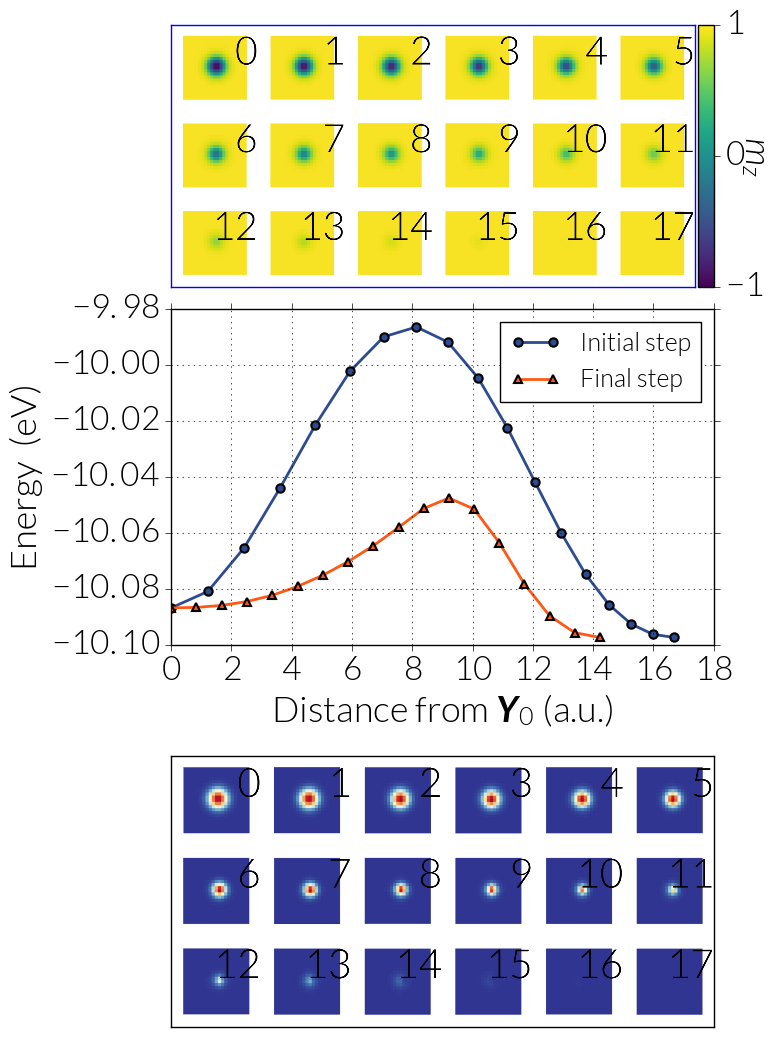

In [12]:
p = npf.plot_dist_vs_energy([
['neb_21x21-spins_fm-sk_atomic_k1e4_energy.ndt', 
 'neb_21x21-spins_fm-sk_atomic_k1e4_dYs.ndt', 
 r'Initial step', 0],
['neb_21x21-spins_fm-sk_atomic_k1e4_energy.ndt', 
 'neb_21x21-spins_fm-sk_atomic_k1e4_dYs.ndt', 
 r'Final step', -1],
],
top_figure='png/neb_21x21-spins_fm-sk_atomic_k1e4_0/grid.png',
bottom_figure='png/neb_21x21-spins_fm-sk_atomic_k1e4_97/grid.png',
cmap='viridis',
legend_position='upper right',
# savef="energy.pdf"
scale=1.602e-19, scale_label='eV',
num_labels=None,
rel_folder=base_folder,
top_figure_frame='blue'
)

# NPF colormaps

The `npf_cm` library contains custom colourmaps and a variety of tools to create your own linear gradients from `HTML` colour values

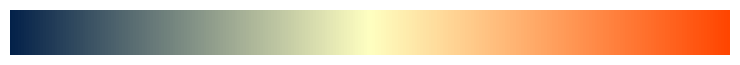

In [13]:
npf_cm.plot_colormap(npf_cm.BuYlOr_mpl)

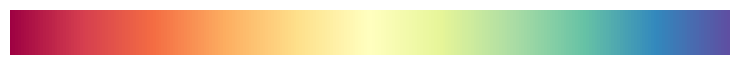

In [14]:
npf_cm.plot_colormap(npf_cm.softrbw_mpl)